# Modelling and Evaluating 

## Objectives

- Answer business requirement 2:
  - The client is interested to tell wheterh a given leaf is covered with powdery mildew 

## Inputs

- inputs/cherryleaves_dataset/cherry-leaves/train
- inputs/cherryleaves_dataset/cherry-leaves/test
- inputs/cherryleaves_dataset/cherry-leaves/validation
- image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Comments | Insights | Conclusions

Basic model - OVERFITTING

---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.image import imread

---

## Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/Detection-Cherry-Powdery-Mildew')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Detection-Cherry-Powdery-Mildew'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'alfa'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Number of images in train, test and validation sets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




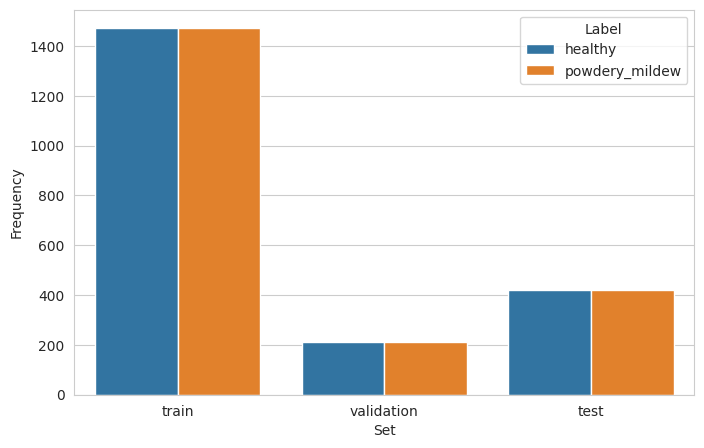

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

### Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255,
                                          )

### Augment training image set

In [25]:
batch_size = 16
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='grayscale',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmentation training image set

(16, 256, 256, 1)


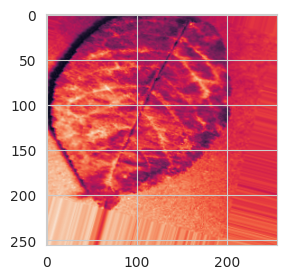

(16, 256, 256, 1)


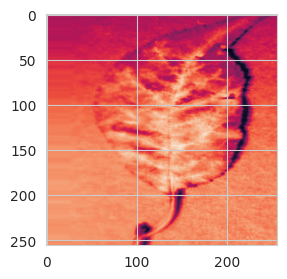

(16, 256, 256, 1)


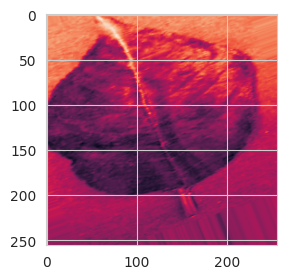

In [13]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment validation image set

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='grayscale',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmentation validation image set

(16, 256, 256, 1)


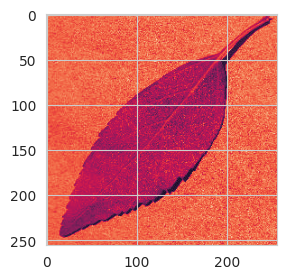

(16, 256, 256, 1)


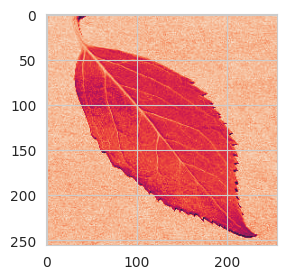

(16, 256, 256, 1)


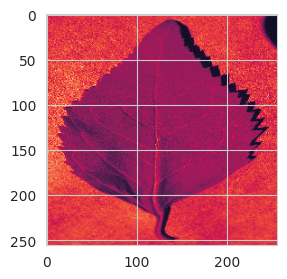

In [15]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = validation_set.next()
    print(img.shape)  # (20,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Augment test image set

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmentation test image set

(16, 256, 256, 1)


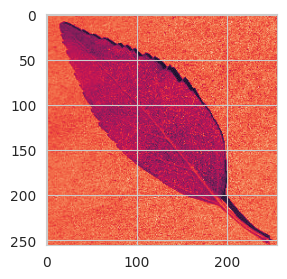

(16, 256, 256, 1)


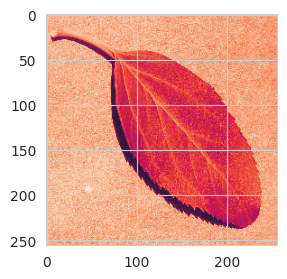

(16, 256, 256, 1)


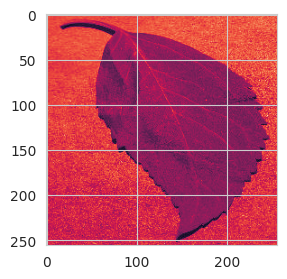

In [17]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/alfa/class_indices.pkl']

---

## Model Creation

### Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Model

In [26]:
def create_tf_model():
    model = Sequential()

    # model.add(Conv2D(filters=32, kernel_size=(3, 3),
    #           input_shape=image_shape, activation='relu', ))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Conv2D(filters=64, kernel_size=(3, 3),
    #           input_shape=image_shape, activation='relu', ))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Conv2D(filters=64, kernel_size=(3, 3),
    #           input_shape=image_shape, activation='relu', ))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Flatten())
    # model.add(Dense(128, activation='relu'))

    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='sigmoid'))

    # model.compile(loss='binary_crossentropy',
    #               optimizer='adam',
    #               metrics=['accuracy'])

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### fully connected layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu')) # ,kernel_regularizer='l1'
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

### Model Summary

In [27]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

### Early Stopping

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

### Fit model for training

In [29]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

IndexError: tuple index out of range

### Save model

In [ ]:
model.save('outputs/alfa/powdery_mildew_model.h5')

---

## Model Performance

### Model learining curve

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Model Evaluation

### Load saved model

In [ ]:
from keras.models import load_model
model = load_model('outputs/alfa/powdery_mildew_model.h5')

### Evaluate model on test set

Accuracy

In [ ]:
evaluation = model.evaluate(test_set)

ROC Curve

In [ ]:
STEP_SIZE_TEST = validation_set.n//validation_set.batch_size
validation_set.reset()
preds = model.predict(validation_set,
verbose=1)

In [ ]:
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
fpr, tpr, _ = roc_curve(validation_set.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix
https://medium.com/analytics-vidhya/how-to-create-a-confusion-matrix-with-the-test-result-in-your-training-model-802b1315d8ee

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Classification report')
    print(classification_report(test_set.classes, y_pred, target_names=labels))

### Save evaluation pickle

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/alfa/evaluation.pkl")

---

## Predict on new data

### Load random image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


### Convert image to array and prepare for prediction

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

### Predict class probabilities

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)